# Implementation of text classification with BERT 

Este notebook se basa en este tutorial de TensorFlow: [Classify text with BERT](https://www.tensorflow.org/tutorials/text/classify_text_with_bert)

*BERT* [(article link)](https://arxiv.org/abs/1810.04805) y otras arquitecturas de codificador *Transformers* han tenido un gran éxito en una variedad de tareas en NLP. Éstos calculan representaciones en el espacio vectorial del lenguaje natural que son adecuadas para su uso en modelos de aprendizaje profundo. Además, *BERT* es un modelo "profundamente bidireccional", esto  significa que  aprende información tanto del lado izquierdo como del derecho del contexto de un token durante la fase de entrenamiento (La bidireccionalidad de un modelo es importante para comprender verdaderamente el significado de un idioma).

Los modelos *BERT* generalmente se entrenan previamente en un gran corpus de texto y luego se ajustan para tareas específicas (https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/).

En el siguiente notebook, vamos a usar un *BERT* preentrenado para calcular representaciones en el espacio vectorial de un conjunto de datos de discurso de odio para alimentar una arquitectura descendiente MLP.


## Instalar paquetes y dependencias necesarias

In [ ]:
# Una dependencia del preprocesamiento para las entradas BERT
!pip install -q tensorflow-text

In [ ]:
!pip install -q tf-models-official

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold,train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil
import os

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.6.0


## Leer y preparar el dataset adecuadamente

In [ ]:
df = pd.read_csv('labeled_data.csv')

In [ ]:
df0 = pd.read_csv('labeled_data.csv', delimiter=',', nrows = nRowsRead)
df0.dataframeName = 'labeled_data.csv'
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 24783 rows and 7 columns


In [ ]:
df0.head(5)

Unnamed: 0  count  ...  class                                              tweet
0           0      3  ...      2  !!! RT @mayasolovely: As a woman you shouldn't...
1           1      3  ...      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2           2      3  ...      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3           3      3  ...      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4           4      6  ...      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

[5 rows x 7 columns]

In [ ]:
# Se realizan ciertos reajustes en el DF para su manejo

c=df0['class']
df0.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)
df

text  ... label
0      !!! RT @mayasolovely: As a woman you shouldn't...  ...     2
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  ...     1
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  ...     1
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  ...     1
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  ...     1
...                                                  ...  ...   ...
24778  you's a muthaf***in lie &#8220;@LifeAsKing: @2...  ...     1
24779  you've gone and broke the wrong heart baby, an...  ...     2
24780  young buck wanna eat!!.. dat nigguh like I ain...  ...     1
24781              youu got wild bitches tellin you lies  ...     1
24782  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...  ...     2

[24783 rows x 3 columns]

In [ ]:
# Si agrupamos los datos por label podemos comprobar el desbalanceo tan significativo que caracteriza el dataset
df.groupby('label').count()

text  category
label                 
0       1430      1430
1      19190     19190
2       4163      4163

In [ ]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))


Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



###  Separar los datos en los conjunto de train, validation y test:

Cabe comentar que se realiza de manera que dicho desbalanceo anteriormente comentado se conserve en los tres subcojuntos de datos.

In [ ]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [ ]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test         143
                         train       1158
                         val          129
neither            2     test         416
                         train       3372
                         val          375
offensive_language 1     test        1920
                         train      15543
                         val         1727

In [ ]:
df

text  ... data_type
0      !!! RT @mayasolovely: As a woman you shouldn't...  ...      test
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  ...     train
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  ...     train
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  ...     train
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  ...     train
...                                                  ...  ...       ...
24778  you's a muthaf***in lie &#8220;@LifeAsKing: @2...  ...     train
24779  you've gone and broke the wrong heart baby, an...  ...     train
24780  young buck wanna eat!!.. dat nigguh like I ain...  ...     train
24781              youu got wild bitches tellin you lies  ...     train
24782  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...  ...     train

[24783 rows x 4 columns]

In [ ]:
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

text  ... data_type
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  ...     train
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  ...     train
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  ...     train
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  ...     train
6  !!!!!!"@__BrighterDays: I can not just sit up ...  ...     train

[5 rows x 4 columns]

In [ ]:
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

text  ... data_type
5   !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...  ...       val
27  " i met that pussy on Ocean Dr . i gave that p...  ...       val
31  " i'd say im back to the old me but my old bit...  ...       val
44     " post a picture of that pussy get 200 likes "  ...       val
46        " quick piece of pussy call it a drive by "  ...       val

[5 rows x 4 columns]

In [ ]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

text  ... data_type
0   !!! RT @mayasolovely: As a woman you shouldn't...  ...      test
12  " So hoes that smoke are losers ? " yea ... go...  ...      test
14                            " bitch get up off me "  ...      test
17                          " bitch who do you love "  ...      test
25     " her pussy lips like Heaven doors " &#128524;  ...      test

[5 rows x 4 columns]

In [ ]:
df.dtypes

text         object
category     object
label         int64
data_type    object
dtype: object

## Construir el input de TensorFlow 

Para ello, nos vamos a basar en (https://www.tensorflow.org/guide/data)

Si bien tf.data intenta propagar la información de la forma, la configuración predeterminada de Dataset.batch da como resultado un tamaño de lote desconocido porque es posible que el último lote no esté lleno. Tengamos en cuenta los Nones en la forma:

batched_dataset
```
<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>
```
Utilizaremos el argumento "drop_remainder" para ignorar ese último lote y obtener la propagación de forma completa:


In [ ]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [ ]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [ ]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [ ]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b"They say life is what you make it bitch but I'm just tryna make it .. Straight up"
 b'I got more trust in drugs then these dumb ass bitches'
 b'RT @WayneL_Jr: LMAOO accurate RT @BasedPaco: When bitches see a "quote with a " tweet on the TL http://t.co/Azl9o3PyZE'
 b'That nigga gucci always hits that hoe when he puts "Rick James" in a song, giving our nigga rick a shoutout #RIPRICK #RICKJAMESBITCH'
 b'niggas need to learn to ride for there homies, not for the crew hoes smfh.'
 b'" these bitches even worst they\'ll send them guys for you "'
 b'&#8220;@lildoll__: grown. mature. pretty. &amp;etc. All that goes out the window when a bitch play with me.&#8221;'
 b"@Yankees isn't that kind of saying the #Braves won't make it to the World Series? LOL"
 b"Stupid bitch at Church's didn't give me my fucking BBQ sauce so now I gotta eat some dry ass chicken strips &#128531;"
 b'@Rock76_ like who let em bring Da heat in dis bitch &#128563;&#128552; .. #linkup bro'
 b"I wanna cut my hai

# Cargar modelos desde TensorFlow Hub


Se ha escogido el modelo de  "bert_en_uncased_L-12_H-768_A-12"

Este modelo de TF Hub usa la implementación de BERT del repositorio de TensorFlow Models que utiliza L = 12 capas ocultas (es decir, bloques de transformadores), un tamaño oculto de H = 768 y A = 12 cabezas de atención.

Cabe comentar que en el proceso de ajuste y testeo se ha probado con la versión de "Albert", pero los resultados obtenidos no han mejorado los que posteriormente se verán. 

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
#bert_model_name = 'albert_en_base'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


### Modelo de preprocesamiento

Las entradas de texto deben transformarse en identificadores de token numéricos y organizarse en varios tensores antes de ingresar a BERT. TensorFlow Hub proporciona un modelo de preprocesamiento coincidente para cada uno de los modelos BERT, que implementa esta transformación mediante operaciones TF de la biblioteca TF.text. Por lo tanto, no es necesario ejecutar código Python puro fuera del modelo de TensorFlow para preprocesar el texto.

El modelo de preprocesamiento debe ser el referenciado por la documentación del modelo BERT, que se puede leer en la URL impresa arriba. Para los modelos BERT del menú desplegable anterior, el modelo de preprocesamiento se selecciona automáticamente.


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Tweet: b'@theshardyrebel #faggot'
Label : 0
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1030  1996  7377 17460  2890  8671  1001  6904 13871  4140   102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.82643986  0.99892515 -0.13997956 -0.14425752  0.49103832  0.45615
  0.9986763  -0.99194145  0.06365459 -0.99938816  0.16349748 -0.7928992 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.0856526   0.5659432   0.24476366 ... -0.3055648   1.585174
   0.10953499]
 [ 0.4786581   1.1078956  -0.306342   ... -0.41391575  0.3448124
   0.5030247 ]
 [ 0.1726994   1.2224103  -0.7325047  ... -0.66137445  0.49749243
   0.3515124 ]
 ...
 [ 0.36447784  0.84689206  0.80516267 ...  0.5134707   0.85816085
   1.0611016 ]
 [-0.06444989  0.0986921   0.45482662 ...  0.4704368   1.9435575
  -0.07758231]
 [-0.04990365  0.69179547  0.3940669  ... -0.540749    1.1115532
   0.3034712 ]]


# Técnicas para manejar con un conjunto de datos desbalanceado

### Calcular los pesos de las clases

Uno de los objetivos es identificar el discurso del odio, pero no tenemos muchas de esas muestras con las que trabajar, por lo que nos gustaría que el clasificador pondera en gran medida los pocos ejemplos disponibles.
Para ello, vamos a forzar esta situación mediante la confiuración de pesos de Keras para cada clase a través de un parámetro. Esto hará que el modelo "preste más atención" a los ejemplos de una clase subrepresentada.

In [ ]:
weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / ofensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


# BERT + MLP

Vamos a crear un modelo simple y ajustado, con el modelo de preprocesamiento, el modelo BERT seleccionado, una capa densa y una capa de dropout.

In [ ]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        #print(output_bias)
        
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)
    
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model(output_bias=initial_output_bias)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.50000393 0.7310405  0.50001913]], shape=(1, 3), dtype=float32)


In [ ]:
classifier_model.get_weights()[-1]

array([ 3.938462, 15.      ,  5.      ], dtype=float32)

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

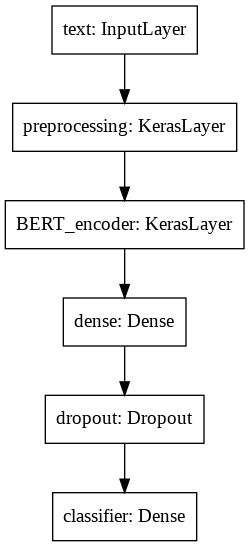

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#metrics = tf.metrics.Accuracy()

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [ ]:
#  classifier_model.compile(optimizer=optimizer,
#                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                           metrics=['accuracy'])
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight).history

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


628/628 [==============================] - 269s 417ms/step - loss: 1.8315 - accuracy: 0.7276 - val_loss: 0.4427 - val_accuracy: 0.8113
Epoch 2/10
628/628 [==============================] - 261s 415ms/step - loss: 0.5488 - accuracy: 0.8377 - val_loss: 0.4006 - val_accuracy: 0.8377
Epoch 3/10
628/628 [==============================] - 261s 415ms/step - loss: 0.4506 - accuracy: 0.8690 - val_loss: 0.4073 - val_accuracy: 0.8548
Epoch 4/10
628/628 [==============================] - 260s 414ms/step - loss: 0.3651 - accuracy: 0.8906 - val_loss: 0.4270 - val_accuracy: 0.8516
Epoch 5/10
628/628 [==============================] - 260s 413ms/step - loss: 0.3118 - accuracy: 0.9125 - val_loss: 0.3114 - val_accuracy: 0.9027
Epoch 6/10
628/628 [==============================] - 260s 413ms/step - loss: 0.2450 - accuracy: 0.9296 - val_loss: 0.3645 - val_accuracy: 0.8920
Epoch 7/10
628/628 [==============================] - 259s 413ms/step - loss: 0.2001 - accuracy: 0.9475 - val_loss: 0.4258 - val_accura

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 14s 176ms/step - loss: 0.4693 - accuracy: 0.9016
Loss: 0.4693325161933899
Accuracy: 0.9015732407569885


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


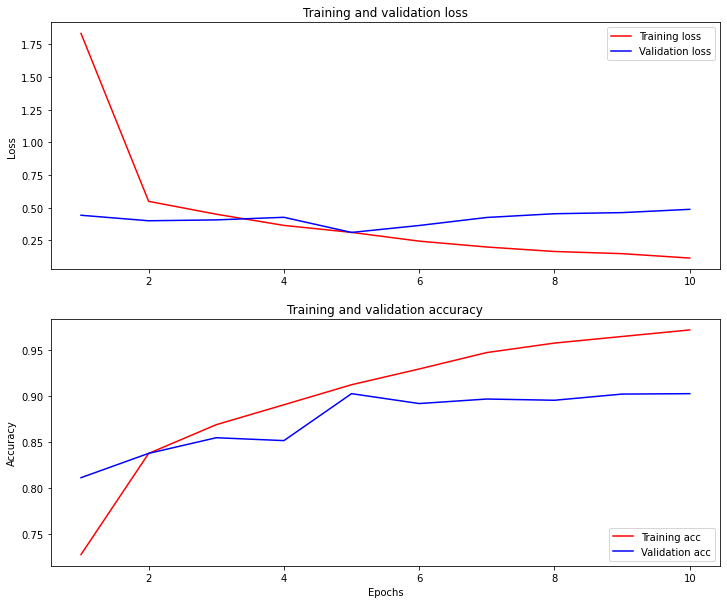

In [ ]:
history_dict = history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Exportar para inferencia

Ahora simplemente guarde su modelo ajustado para usarlo más adelante.

Parte de guardado del modelo -- Carga del modelo

In [ ]:
dataset_name = 'mlp_10_hate_speech'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
examples = ["hoes loyal"]

reloaded_results = reloaded_model(tf.constant(examples)).numpy()

print('Results from the saved model:')

print(np.argmax(reloaded_results))

Results from the saved model:
1


# Resultados de MLP

In [ ]:
result =  classifier_model.predict(test_ds)
print(result.shape)

(2479, 3)


In [ ]:
result[0:2]

array([[0.000023  , 0.99994695, 0.00002998],
       [0.0000048 , 0.9999881 , 0.0000071 ]], dtype=float32)

In [ ]:
classes = np.argmax(result, axis=-1)

### Hacer predicciones y guardar en np.array

In [ ]:
tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(classifier_model.predict(tweet))

In [ ]:
test_labels[0:2]

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 2]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]

In [ ]:
predictions[0:2]

[array([[0.00007668, 0.99989927, 0.00002407],
        [0.0002324 , 0.9997538 , 0.00001378],
        [0.00013302, 0.99981326, 0.00005374],
        [0.00008286, 0.99990296, 0.00001418],
        [0.00005487, 0.9983595 , 0.00158562],
        [0.00004942, 0.9998566 , 0.0000939 ],
        [0.00004589, 0.9997218 , 0.00023232],
        [0.00001926, 0.9999684 , 0.00001228],
        [0.00165156, 0.9983292 , 0.00001929],
        [0.00005257, 0.99930406, 0.00064337],
        [0.27613282, 0.7130907 , 0.01077649],
        [0.00001563, 0.9999453 , 0.00003909],
        [0.0000283 , 0.9999474 , 0.00002433],
        [0.00316797, 0.9967193 , 0.00011274],
        [0.00004907, 0.99960107, 0.00034983],
        [0.00110798, 0.9988732 , 0.00001884],
        [0.04455452, 0.9551338 , 0.00031162],
        [0.00001428, 0.9999701 , 0.00001557],
        [0.00004903, 0.99991214, 0.00003882],
        [0.00004621, 0.00066885, 0.9992849 ],
        [0.00002239, 0.99996054, 0.00001708],
        [0.00003331, 0.9999453 , 0

In [ ]:
from itertools import chain
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)

In [ ]:
y_test = np.array(list(chain.from_iterable(test_labels)))

## Performance del modelo

A través de la matriz de confusión, podemos valorar y comparar el performance del modelo implementado en este notebook. 

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_recall_curve,make_scorer, recall_score, accuracy_score, precision_score

print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_pred)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred)))

Confussion matrix:
[[  67   63   13]
 [  88 1797   35]
 [  13   32  371]]

Classification report:
              precision    recall  f1-score   support

           0       0.40      0.47      0.43       143
           1       0.95      0.94      0.94      1920
           2       0.89      0.89      0.89       416

    accuracy                           0.90      2479
   macro avg       0.74      0.77      0.75      2479
weighted avg       0.91      0.90      0.90      2479

Accuracy score:0.9015732150060508


### Comentarios

Se debe mencionar que parte de un modelo basado en una arquitectura MLP, también se consideró uno con CNN. Aún aumentando la complejidad del algoritmo los resultados no eran mejores que el primer caso. 
